In [ ]:
!python -m spacy download en_core_web_lg

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_lg
import string
import re
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam

In [ ]:
train_data = pd.read_csv('twitter_training.csv', header=None)
val_data = pd.read_csv('twitter_validation.csv', header=None)

train_data.columns = ['id', 'name', 'sentiment', 'text']
val_data.columns = ['id', 'name', 'sentiment', 'text']

In [ ]:
train_data.head(4)

,id,name,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...


In [ ]:
train_data.tail(4)

,id,name,sentiment,text
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...
74681,9200,Nvidia,Positive,Just like the windows partition of my Mac is l...


In [ ]:
val_data.head(4)

,id,name,sentiment,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."


In [ ]:
val_data.tail(4)

,id,name,sentiment,text
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.
999,6960,johnson&johnson,Neutral,Johnson & Johnson to stop selling talc baby po...


In [ ]:
train_data.drop(['id', 'name'], axis=1, inplace=True)
train_data.head(4)

,sentiment,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...


In [ ]:
val_data.drop(['id', 'name'], axis=1, inplace=True)
val_data.head(4)

,sentiment,text
0,Irrelevant,I mentioned on Facebook that I was struggling ...
1,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,Negative,@Microsoft Why do I pay for WORD when it funct...
3,Negative,"CSGO matchmaking is so full of closet hacking,..."


<Axes: xlabel='sentiment', ylabel='count'>

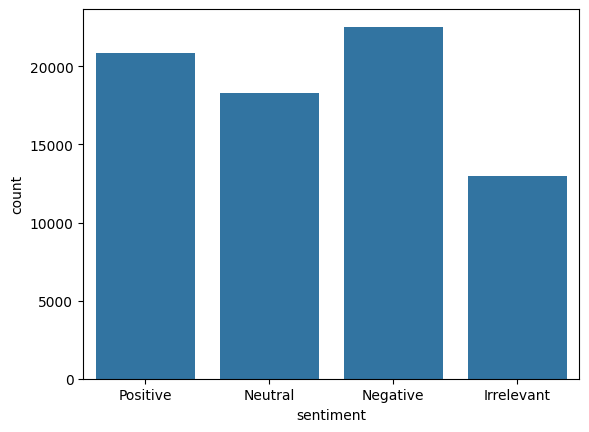

In [ ]:
sns.countplot(train_data, x='sentiment')

<Axes: xlabel='sentiment', ylabel='count'>

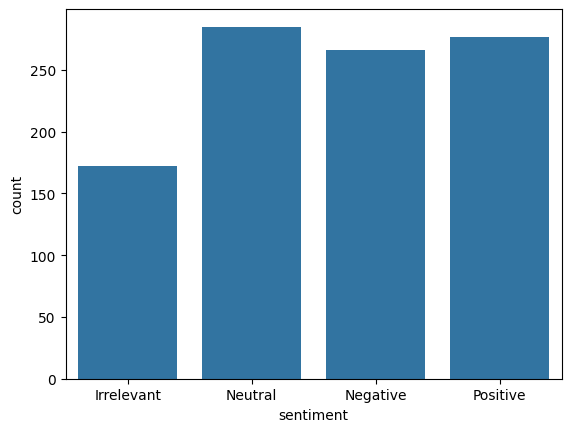

In [ ]:
sns.countplot(val_data, x='sentiment')

In [ ]:
nlp = en_core_web_lg.load()
nlp

In [ ]:
train_data = train_data.loc[train_data['sentiment'] != "Irrelevant"]
val_data = val_data.loc[val_data['sentiment'] != "Irrelevant"]

In [ ]:
train_data['sentiment'].unique()

array(['Positive', 'Neutral', 'Negative'], dtype=object)

In [ ]:
val_data['sentiment'].unique()

array(['Neutral', 'Negative', 'Positive'], dtype=object)

In [ ]:
def pre_processing(text):

    text = re.sub(r'http\S+', '', text)  # remove links
    text = re.sub(r'@\S+', '', text)  # remove mentions
    text = re.sub(r'[^A-Za-z0-9\s]', '', text) # everything except letters

    # Process text with spacy
    documento = nlp(text)

    lista = []
    for token in documento:
      lista.append(token.lemma_)


    lista = [palavra for palavra in lista if palavra not in STOP_WORDS and palavra not in string.punctuation]
    lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])

    return lista.lower().strip()

In [ ]:
train_data['text'] = train_data['text'].astype(str)
val_data['text'] = val_data['text'].astype(str)

train_data['cleaned_text'] = train_data['text'].apply(pre_processing)
val_data['cleaned_text'] = val_data['text'].apply(pre_processing)

In [ ]:
le = LabelEncoder()
le.fit(train_data['sentiment'])

LabelEncoder()

In [ ]:
y_train = le.transform(train_data['sentiment'])
y_val = le.transform(val_data['sentiment'])

In [ ]:
le.classes_

array(['Negative', 'Neutral', 'Positive'], dtype=object)

In [ ]:
mapping = {
    0 : 'Negative',
    1 : 'Neutral',
    2 : 'Positive'
}

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>', lower=True)
tokenizer.fit_on_texts(train_data['cleaned_text'])


x_train_seq = tokenizer.texts_to_sequences(train_data['cleaned_text'])
x_val_seq = tokenizer.texts_to_sequences(val_data['cleaned_text'])


max_length = 100
x_train_pad = pad_sequences(x_train_seq, maxlen=max_length, padding='post', truncating='post')
x_val_pad = pad_sequences(x_val_seq, maxlen=max_length, padding='post', truncating='post')

In [ ]:
y_train_category = to_categorical(y_train, num_classes=3)
y_val_category = to_categorical(y_val, num_classes=3)

In [ ]:
x_train_pad.shape, y_train_category.shape

((61692, 100), (61692, 3))

In [ ]:
x_val_pad.shape, y_val_category.shape

((828, 100), (828, 3))

In [ ]:
max_features = len(tokenizer.word_index) + 1
output_dim = 64

max_features

30137

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=output_dim))
model.add(LSTM(64, return_sequences=True))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(le.classes_), activation='softmax'))
model.summary()

In [ ]:
optimizer = Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

In [ ]:
history = model.fit(
    x_train_pad, y_train_category,
    epochs=40,
    batch_size=32,
    validation_data=(x_val_pad, y_val_category),
    callbacks=[early_stop]
)

Epoch 1/40
1928/1928 ━━━━━━━━━━━━━━━━━━━━ 151s 77ms/step - accuracy: 0.3820 - loss: 1.0881 - val_accuracy: 0.5821 - val_loss: 0.9184
Epoch 2/40
1928/1928 ━━━━━━━━━━━━━━━━━━━━ 199s 76ms/step - accuracy: 0.5721 - loss: 0.9231 - val_accuracy: 0.8237 - val_loss: 0.4936
Epoch 3/40
1928/1928 ━━━━━━━━━━━━━━━━━━━━ 202s 75ms/step - accuracy: 0.7672 - loss: 0.6146 - val_accuracy: 0.8877 - val_loss: 0.3564
Epoch 4/40
1928/1928 ━━━━━━━━━━━━━━━━━━━━ 146s 75ms/step - accuracy: 0.8250 - loss: 0.4586 - val_accuracy: 0.8986 - val_loss: 0.2927
Epoch 5/40
1928/1928 ━━━━━━━━━━━━━━━━━━━━ 202s 76ms/step - accuracy: 0.8504 - loss: 0.3829 - val_accuracy: 0.9058 - val_loss: 0.2732
Epoch 6/40
1928/1928 ━━━━━━━━━━━━━━━━━━━━ 202s 76ms/step - accuracy: 0.8761 - loss: 0.3078 - val_accuracy: 0.9167 - val_loss: 0.2136
Epoch 7/40
1928/1928 ━━━━━━━━━━━━━━━━━━━━ 199s 74ms/step - accuracy: 0.8881 - loss: 0.2735 - val_accuracy: 0.9336 - val_loss: 0.2058
Epoch 8/40
1928/1928 ━━━━━━━━━━━━━━━━━━━━ 203s 75ms/step - accuracy: 

In [ ]:
loss, accuracy = model.evaluate(x_val_pad, y_val_category)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9358 - loss: 0.1707


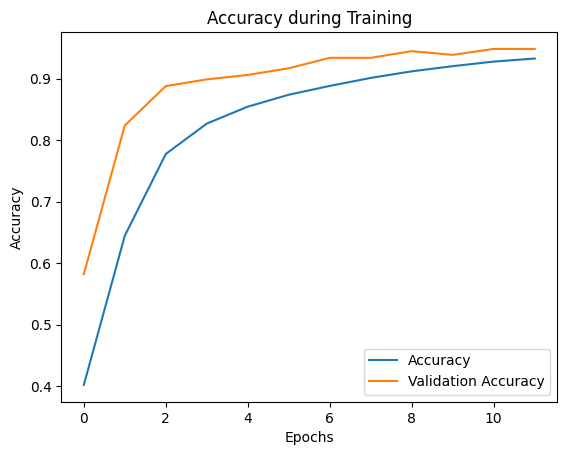

In [ ]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

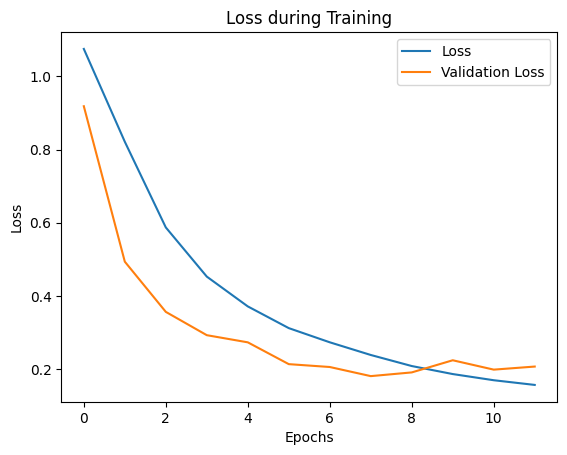

In [ ]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()